# Hansard2Vec

Adapted from Thrones2Vec

© Yuriy Guts, 2016

N.b. Needs to run in Python 2

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\Users\rothw\Anaconda3\envs\py27\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [7]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rothw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rothw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus - for Hansard, probably need to do as one debate at a time, as little or no pattern across debates

**Load books from files**

In [6]:
book_filenames = sorted(glob.glob("C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\*.txt"))
# book_filenames = sorted(glob.glob("C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\President Trump- State Visit 2017-02-20.txt"))

In [7]:
print("Found books:")
book_filenames

Found books:


['C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\Armed Forces- Historical Cases 2017-02-23.txt',
 'C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\Aster Group Housing Association 2017-02-22.txt',
 'C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\HIV Awareness- PSHE Lessons 2017-02-24.txt',
 'C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\High Speed 2 (Newton) 2017-02-23.txt',
 'C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\High Speed Rail (London - West Midlands) Bill 2017-02-20.txt',
 'C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\Jamal al-Harith 2017-02-23.txt',
 'C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\Lee Valley Regional Park (Amendment) 2017-02-22.txt',
 'C:\\Users\\rothw\\Documents\\Python Scripts\\Python NLP\\Hansard data\\debates\\Local Governm

**Combine the books into one string**

In [8]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'C:\Users\rothw\Documents\Python Scripts\Python NLP\Hansard data\debates\Armed Forces- Historical Cases 2017-02-23.txt'...
Corpus is now 152532 characters long

Reading 'C:\Users\rothw\Documents\Python Scripts\Python NLP\Hansard data\debates\Aster Group Housing Association 2017-02-22.txt'...
Corpus is now 180874 characters long

Reading 'C:\Users\rothw\Documents\Python Scripts\Python NLP\Hansard data\debates\HIV Awareness- PSHE Lessons 2017-02-24.txt'...
Corpus is now 201168 characters long

Reading 'C:\Users\rothw\Documents\Python Scripts\Python NLP\Hansard data\debates\High Speed 2 (Newton) 2017-02-23.txt'...
Corpus is now 224142 characters long

Reading 'C:\Users\rothw\Documents\Python Scripts\Python NLP\Hansard data\debates\High Speed Rail (London - West Midlands) Bill 2017-02-20.txt'...
Corpus is now 289411 characters long

Reading 'C:\Users\rothw\Documents\Python Scripts\Python NLP\Hansard data\debates\Jamal al-Harith 2017-02-23.txt'...
Corpus is now 325087 characters lon

**Split the corpus into sentences**

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [11]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [12]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [13]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

We have always sought to use our parliamentary time to raise issues that are of concern to those people; I am glad to do so again today.
[u'We', u'have', u'always', u'sought', u'to', u'use', u'our', u'parliamentary', u'time', u'to', u'raise', u'issues', u'that', u'are', u'of', u'concern', u'to', u'those', u'people', u'I', u'am', u'glad', u'to', u'do', u'so', u'again', u'today']


In [14]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 171,234 tokens


## Train Word2Vec

In [15]:
# Dimensionality of the resulting word vectors.
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 12

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [16]:
hansard2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [17]:
hansard2vec.build_vocab(sentences)

2017-07-24 08:57:28,075 : INFO : collecting all words and their counts
2017-07-24 08:57:28,084 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-07-24 08:57:28,263 : INFO : collected 9972 word types from a corpus of 171234 raw words and 7966 sentences
2017-07-24 08:57:28,276 : INFO : Loading a fresh vocabulary
2017-07-24 08:57:28,377 : INFO : min_count=3 retains 4553 unique words (45% of original 9972, drops 5419)
2017-07-24 08:57:28,385 : INFO : min_count=3 leaves 164348 word corpus (95% of original 171234, drops 6886)
2017-07-24 08:57:28,667 : INFO : deleting the raw counts dictionary of 9972 items
2017-07-24 08:57:28,677 : INFO : sample=0.001 downsamples 51 most-common words
2017-07-24 08:57:28,686 : INFO : downsampling leaves estimated 120512 word corpus (73.3% of prior 164348)
2017-07-24 08:57:28,698 : INFO : estimated required memory for 4553 words and 300 dimensions: 13203700 bytes
2017-07-24 08:57:28,881 : INFO : resetting layer weights


In [18]:
print("Word2Vec vocabulary length:", len(hansard2vec.wv.vocab))

Word2Vec vocabulary length: 4553


**Start training, this might take a minute or two...**

In [19]:
hansard2vec.train(sentences, total_examples=hansard2vec.corpus_count, epochs=hansard2vec.iter)

2017-07-24 08:57:39,628 : INFO : training model with 4 workers on 4553 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=12
2017-07-24 08:57:41,424 : INFO : PROGRESS: at 1.11% examples, 4477 words/s, in_qsize 8, out_qsize 0
2017-07-24 08:57:42,717 : INFO : PROGRESS: at 5.73% examples, 12317 words/s, in_qsize 8, out_qsize 0
2017-07-24 08:57:43,861 : INFO : PROGRESS: at 11.65% examples, 17688 words/s, in_qsize 8, out_qsize 0
2017-07-24 08:57:45,042 : INFO : PROGRESS: at 16.35% examples, 19065 words/s, in_qsize 8, out_qsize 0
2017-07-24 08:57:46,081 : INFO : PROGRESS: at 22.12% examples, 21522 words/s, in_qsize 7, out_qsize 0
2017-07-24 08:57:47,276 : INFO : PROGRESS: at 25.59% examples, 20920 words/s, in_qsize 8, out_qsize 0
2017-07-24 08:57:48,436 : INFO : PROGRESS: at 28.89% examples, 20534 words/s, in_qsize 8, out_qsize 0
2017-07-24 08:57:49,573 : INFO : PROGRESS: at 33.78% examples, 21069 words/s, in_qsize 8, out_qsize 0
2017-07-24 08:57:50,910 : INFO : PROG

602309

**Save to file, can be useful later**

In [20]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [21]:
hansard2vec.save(os.path.join("trained", "hansard2vec.w2v"))

2017-07-24 08:58:39,796 : INFO : saving Word2Vec object under trained\hansard2vec.w2v, separately None
2017-07-24 08:58:39,803 : INFO : not storing attribute syn0norm
2017-07-24 08:58:39,813 : INFO : not storing attribute cum_table
2017-07-24 08:58:40,457 : INFO : saved trained\hansard2vec.w2v


## Explore the trained model.

In [22]:
hansard2vec = w2v.Word2Vec.load(os.path.join("trained", "hansard2vec.w2v"))

2017-07-24 08:58:45,355 : INFO : loading Word2Vec object from trained\hansard2vec.w2v
2017-07-24 08:58:45,492 : INFO : loading wv recursively from trained\hansard2vec.w2v.wv.* with mmap=None
2017-07-24 08:58:45,503 : INFO : setting ignored attribute syn0norm to None
2017-07-24 08:58:45,517 : INFO : setting ignored attribute cum_table to None
2017-07-24 08:58:45,529 : INFO : loaded trained\hansard2vec.w2v


### Compress the word vectors into 2D space and plot them

In [23]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [24]:
all_word_vectors_matrix = hansard2vec.wv.syn0

**Train t-SNE, this could take a minute or two...**

In [25]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [26]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[hansard2vec.wv.vocab[word].index])
            for word in hansard2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [27]:
points.head(10)

,word,x,y
0,secondly,4.410511,-1.164514
1,wetlands,1.127435,-5.318571
2,Sadly,2.287567,-3.981408
3,limited,3.007473,3.659074
4,child,2.268232,5.586239
5,desirable,-2.911330,-0.828606
6,felt,-0.820308,-8.898652
7,four,-1.773763,8.797411
8,facilities,-2.561184,5.192980
9,Does,-8.805049,-4.736904


In [28]:
sns.set_context("poster")

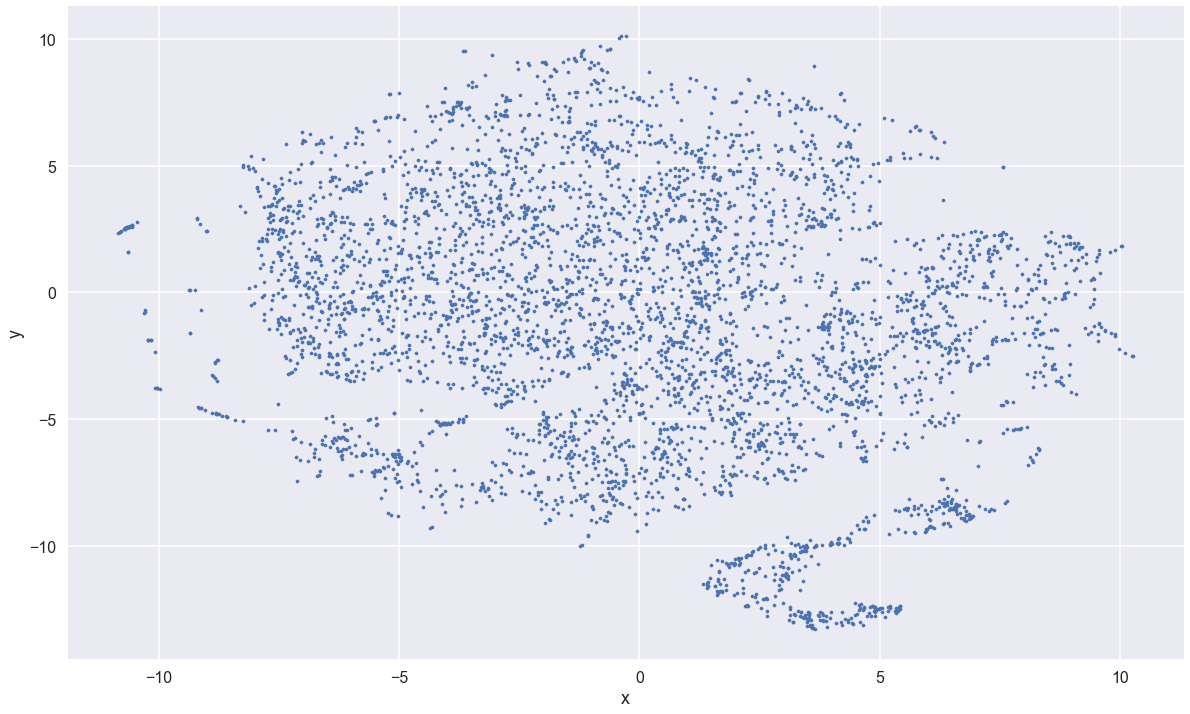

In [29]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [30]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**Example 1**

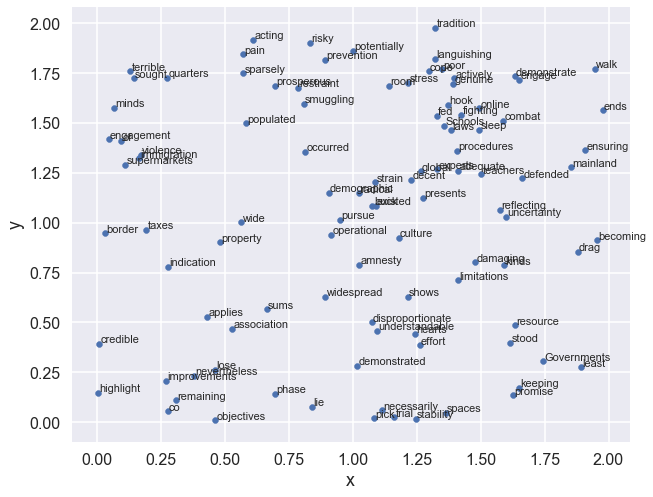

In [32]:
plot_region(x_bounds=(0, 2), y_bounds=(0, 2))

**Example 2**

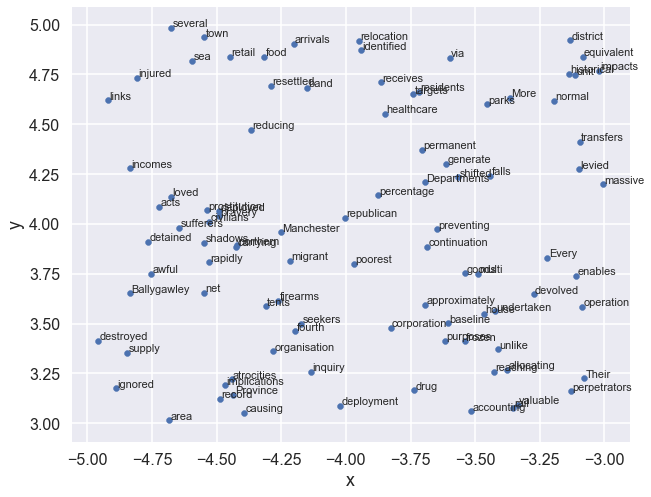

In [33]:
plot_region(x_bounds=(-5, -3), y_bounds=(3, 5))

In [59]:
points.loc[points['word'] == 'Cambridgeshire']

,word,x,y
47,Cambridgeshire,4.667336,-12.41912


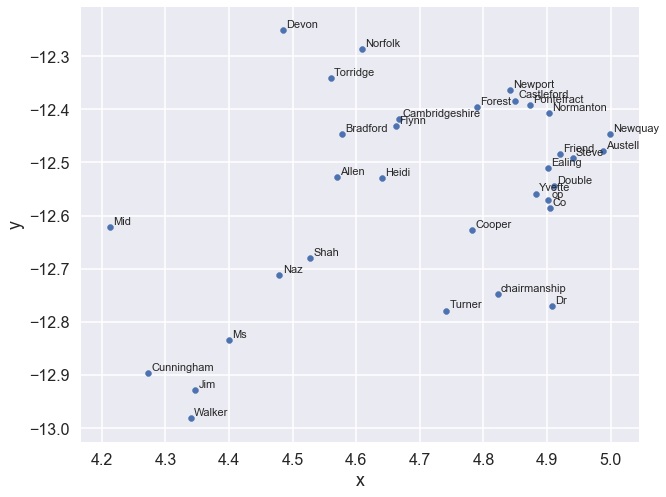

In [61]:
plot_region(x_bounds=(4, 5), y_bounds=(-13, -12))

In [63]:
points.loc[points['word'] == 'Wirral']

,word,x,y
1411,Wirral,5.178074,-12.399685


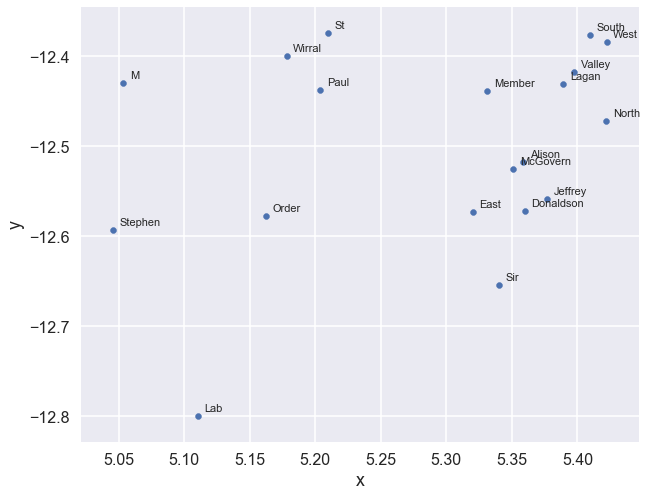

In [76]:
plot_region(x_bounds=(5, 6), y_bounds=(-13, -10))

In [67]:
points.loc[points['word'] == 'Loughborough']

,word,x,y
435,Loughborough,3.436091,-10.099492


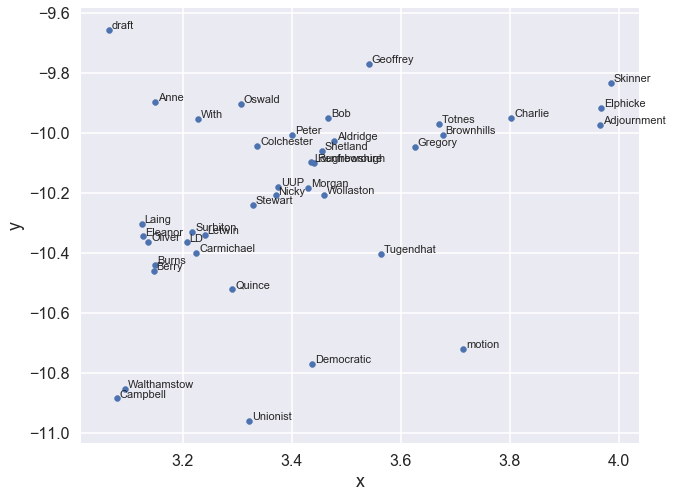

In [73]:
plot_region(x_bounds=(3, 4), y_bounds=(-11, -9))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [34]:
hansard2vec.most_similar("Trump")

2017-07-24 09:18:36,446 : INFO : precomputing L2-norms of word weight vectors


[(u'Donald', 0.9420287609100342),
 (u'President', 0.9396904706954956),
 (u'man', 0.8994383811950684),
 (u'days', 0.880670964717865),
 (u'American', 0.878676176071167),
 (u'presidency', 0.8650749921798706),
 (u'visit', 0.8644853830337524),
 (u'invited', 0.8563025593757629),
 (u'petition', 0.8518103957176208),
 (u'ban', 0.8508844375610352)]

In [116]:
# hansard2vec.most_similar("MP")

In [35]:
hansard2vec.most_similar("Conservative")

[(u'meeting', 0.9570465683937073),
 (u'parties', 0.9565300941467285),
 (u'Labour', 0.9561212062835693),
 (u'letter', 0.9560208320617676),
 (u'petitions', 0.9558033347129822),
 (u'Dispatch', 0.9557292461395264),
 (u'afternoon', 0.954395592212677),
 (u'wrote', 0.9518409371376038),
 (u'Box', 0.9498228430747986),
 (u'update', 0.9493172764778137)]

In [36]:
hansard2vec.most_similar("Lab")

[(u'Co', 0.9756642580032349),
 (u'Stephen', 0.9752426147460938),
 (u'op', 0.9744076132774353),
 (u'Dr', 0.9675081968307495),
 (u'Pound', 0.9657156467437744),
 (u'Jim', 0.9638655185699463),
 (u'beg', 0.9621988534927368),
 (u'Ms', 0.9619714617729187),
 (u'SNP', 0.9619603753089905),
 (u'Cooper', 0.9616819620132446)]

In [37]:
hansard2vec.most_similar("Brexit")

[(u'suggesting', 0.9731744527816772),
 (u'refreshing', 0.970203697681427),
 (u'thinks', 0.9701822996139526),
 (u'red', 0.9699490070343018),
 (u'story', 0.9684762954711914),
 (u'carpet', 0.9672256708145142),
 (u'news', 0.9666416645050049),
 (u'press', 0.9639487862586975),
 (u'anyone', 0.9638791084289551),
 (u'happens', 0.9638589024543762)]

In [38]:
hansard2vec.most_similar("EU")

[(u'wage', 0.9835377335548401),
 (u'anywhere', 0.9828066825866699),
 (u'bearing', 0.9824692606925964),
 (u'systems', 0.9820059537887573),
 (u'operating', 0.9811339974403381),
 (u'unlikely', 0.9802861213684082),
 (u'whereby', 0.9798201322555542),
 (u'aid', 0.9794670939445496),
 (u'forms', 0.9791354537010193),
 (u'cities', 0.9789089560508728)]

In [39]:
hansard2vec.most_similar("Parliament")

[(u'Houses', 0.9281321167945862),
 (u'White', 0.9181728959083557),
 (u'month', 0.9163743853569031),
 (u'length', 0.915817379951477),
 (u'Obama', 0.9105889201164246),
 (u'visits', 0.9082813262939453),
 (u'petitions', 0.9080450534820557),
 (u'invited', 0.9033149480819702),
 (u'both', 0.9031774997711182),
 (u'received', 0.9017024040222168)]

In [55]:
hansard2vec.most_similar("Cambridgeshire")

[(u'Heidi', 0.9965529441833496),
 (u'Allen', 0.9958840608596802),
 (u'Normanton', 0.9932683706283569),
 (u'Newport', 0.9921513795852661),
 (u'Pontefract', 0.9921439290046692),
 (u'Down', 0.9921026229858398),
 (u'Forest', 0.9920272827148438),
 (u'Flynn', 0.992007851600647),
 (u'Ealing', 0.9918324947357178),
 (u'M', 0.9917488098144531)]

In [56]:
hansard2vec.most_similar("Heidi")

[(u'Allen', 0.998035728931427),
 (u'Cambridgeshire', 0.9965530633926392),
 (u'Ealing', 0.9946914315223694),
 (u'Cox', 0.9943478107452393),
 (u'Double', 0.9942461848258972),
 (u'Yvette', 0.9941610097885132),
 (u'Central', 0.9940467476844788),
 (u'Naz', 0.9939398765563965),
 (u'Antrim', 0.9932080507278442),
 (u'Shah', 0.9930828809738159)]

In [57]:
hansard2vec.most_similar("Loughborough")

[(u'Nicky', 0.9984793663024902),
 (u'Morgan', 0.9966331124305725),
 (u'Burns', 0.9961207509040833),
 (u'Aldridge', 0.9958093166351318),
 (u'Renfrewshire', 0.9954527020454407),
 (u'Stewart', 0.9952285289764404),
 (u'Drax', 0.995154082775116),
 (u'Letwin', 0.9950525760650635),
 (u'Oliver', 0.9946845173835754),
 (u'Totnes', 0.9946068525314331)]

In [58]:
hansard2vec.most_similar("Wirral")

[(u'Norfolk', 0.989556074142456),
 (u'Newport', 0.9881231784820557),
 (u'Pontefract', 0.9872677326202393),
 (u'Lagan', 0.9868791103363037),
 (u'Normanton', 0.9866916537284851),
 (u'Castleford', 0.9865404367446899),
 (u'Flynn', 0.9862862229347229),
 (u'Cambridgeshire', 0.9862712621688843),
 (u'M', 0.9856827259063721),
 (u'Paul', 0.9855756759643555)]

**Linear relationships between word pairs**

In [40]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = hansard2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [42]:
nearest_similarity_cosmul("Lammy", "Tottenham", "Chelmsford")
nearest_similarity_cosmul("Gordon", "Salmond", "Flynn")
nearest_similarity_cosmul("Burns", "Chelmsford", "Tottenham")
nearest_similarity_cosmul("McGovern", "Alison", "Elphicke")
nearest_similarity_cosmul("Paul", "Flynn", "Trump")
nearest_similarity_cosmul("Lammy", "Tottenham", "Chelmsford")
nearest_similarity_cosmul("Shah", "Bradford", "Kingston")
nearest_similarity_cosmul("Pauline", "Latham", "Cooper")

Lammy is related to Tottenham, as Dawn is related to Chelmsford
Gordon is related to Salmond, as gave is related to Flynn
Burns is related to Chelmsford, as Dundee is related to Tottenham
McGovern is related to Alison, as Charlie is related to Elphicke
Paul is related to Flynn, as President is related to Trump
Lammy is related to Tottenham, as Dawn is related to Chelmsford
Shah is related to Bradford, as Caroline is related to Kingston
Pauline is related to Latham, as Yvette is related to Cooper


u'Yvette'

In [81]:
# Exploiting "hon. member for" langauge structure

nearest_similarity_cosmul("Allen", "Cambridgeshire", "Wirral")
nearest_similarity_cosmul("Heidi", "Cambridgeshire", "Wirral")

nearest_similarity_cosmul("Allen", "Cambridgeshire", "Loughborough")
nearest_similarity_cosmul("Heidi", "Cambridgeshire", "Loughborough")

nearest_similarity_cosmul("Allen", "Cambridgeshire", "Derbyshire")

nearest_similarity_cosmul("Loughborough", "Morgan", "Allen")
nearest_similarity_cosmul("Morgan", "Loughborough", "Cambridgeshire")

nearest_similarity_cosmul("McGovern", "Wirral", "Derbyshire")
nearest_similarity_cosmul("Wirral", "McGovern", "Latham")

nearest_similarity_cosmul("McGovern", "Wirral", "Loughborough")
nearest_similarity_cosmul("McGovern", "Wirral", "Derbyshire")

Allen is related to Cambridgeshire, as Alison is related to Wirral
Heidi is related to Cambridgeshire, as Alison is related to Wirral
Allen is related to Cambridgeshire, as Morgan is related to Loughborough
Heidi is related to Cambridgeshire, as Morgan is related to Loughborough
Allen is related to Cambridgeshire, as Latham is related to Derbyshire
Loughborough is related to Morgan, as Cambridgeshire is related to Allen
Morgan is related to Loughborough, as Heidi is related to Cambridgeshire
McGovern is related to Wirral, as Latham is related to Derbyshire
Wirral is related to McGovern, as Derbyshire is related to Latham
McGovern is related to Wirral, as Tom is related to Loughborough
McGovern is related to Wirral, as Latham is related to Derbyshire


u'Latham'

## Scrap code